In [2]:
import os
import pandas as pd
import numpy as np
from glob import glob
from datetime import timedelta
from scipy.signal import butter, filtfilt
import datetime


In [13]:
cropped_data_path = "/home/palotti/github/sleep_classifiers/outputs/"

allfiles = glob( cropped_data_path + "cropped/*_cleaned_hr.out")

pids = list(set(os.path.basename(f).split("_")[0] for f in allfiles))
len(pids)

31

In [14]:
def get_hr_file(pid):
    file = cropped_data_path + "cropped/%s_cleaned_hr.out" % (pid)
    df = pd.read_csv(file, names=["time", "hr"], sep=" ")
    df["timedelta"] = df["time"].apply(lambda x : timedelta(seconds=x))
    return df

def get_activity_file(pid):
    file = cropped_data_path + "cropped/%s_cleaned_motion.out" % (pid)
    df = pd.read_csv(file, names=["time", "x", "y", "z"], sep=" ")
    df["timedelta"] = df["time"].apply(lambda x : timedelta(seconds=x))
    return df  

def get_psg_file(pid):
    file = cropped_data_path + "cropped/%s_cleaned_psg.out" % (pid)
    df = pd.read_csv(file, names=["time", "label"], sep=" ")
    df["timedelta"] = df["time"].apply(lambda x : timedelta(seconds=x))
    return df.set_index("timedelta").resample("15s").mean().interpolate().reset_index()
    

In [15]:
def get_consecutive_series(df_in, col):
    df = df_in.copy()

    df["_lenght"] = 0
    df["_seq_id"] = df.groupby((df[col] != df[col].shift(1).fillna(False)).cumsum()).ngroup()
    df["_lenght"] = df[["_lenght", "_seq_id"]].groupby("_seq_id").transform("count")

    return df["_lenght"], df["_seq_id"]

In [16]:
def max2epochs(data, fs, epoch):
    data = data.flatten()

    seconds = int(np.floor(np.shape(data)[0] / fs))
    data = np.abs(data)
    data = data[0:int(seconds * fs)]

    data = data.reshape(fs, seconds, order='F').copy()

    data = data.max(0)
    data = data.flatten()
    N = np.shape(data)[0]
    num_epochs = int(np.floor(N / epoch))
    data = data[0:(num_epochs * epoch)]

    data = data.reshape(epoch, num_epochs, order='F').copy()
    epoch_data = np.sum(data, axis=0)
    epoch_data = epoch_data.flatten()

    return epoch_data

In [17]:
def build_activity_counts_without_matlab(data):

    fs = 50
    time = np.arange(np.amin(data[:, 0]), np.amax(data[:, 0]), 1.0 / fs)
    z_data = np.interp(time, data[:, 0], data[:, 3])

    cf_low = 3
    cf_hi = 11
    order = 5
    w1 = cf_low / (fs / 2)
    w2 = cf_hi / (fs / 2)
    pass_band = [w1, w2]
    b, a = butter(order, pass_band, 'bandpass')

    z_filt = filtfilt(b, a, z_data)
    z_filt = np.abs(z_filt)
    top_edge = 5
    bottom_edge = 0
    number_of_bins = 128

    bin_edges = np.linspace(bottom_edge, top_edge, number_of_bins + 1)
    binned = np.digitize(z_filt, bin_edges)
    epoch = 15
    counts = max2epochs(binned, fs, epoch)
    counts = (counts - 18) * 3.07
    counts[counts < 0] = 0

    time_counts = np.linspace(np.min(data[:, 0]), max(data[:, 0]), np.shape(counts)[0])
    time_counts = np.expand_dims(time_counts, axis=1)
    counts = np.expand_dims(counts, axis=1)
    output = np.hstack((time_counts, counts))

    #activity_count_output_path = ActivityCountService.get_cropped_file_path(subject_id)
    #np.savetxt(activity_count_output_path, output, fmt='%f', delimiter=',')
    return output

In [18]:
def get_counts(df_act):
    data = df_act[["time", "x","y","z"]].values
    # extracts the activity counts
    counts = pd.DataFrame(build_activity_counts_without_matlab(data), columns=["time", "counts"])
    counts["timedelta"] = counts["time"].apply(lambda x : timedelta(seconds=x))
    return counts

In [19]:
def merge_dfs(df_counts, df_act, df_hr, df_psg):

    tol = pd.Timedelta('15s')
    
    merged = pd.merge_asof(left=df_act,
                  right=df_counts,
                  right_on="timedelta",
                  left_on="timedelta",
                  direction='nearest',
                  suffixes=("_act", "_count"),
                  tolerance=tol)
    
    merged = pd.merge_asof(left=merged,
                           right=df_hr,
                           right_on="timedelta",
                           left_on="timedelta",
                           direction='nearest',
                           suffixes=("", "_hr"),
                           tolerance=tol)
    merged["time_hr"] = merged["time"]
    merged.drop(["time"], axis=1, inplace=True)
    
    merged = pd.merge_asof(left=merged,
                           right=df_psg,
                           right_on="timedelta",
                           left_on="timedelta",
                           direction='nearest',
                           suffixes=("", "_psg"),
                           tolerance=tol)
    merged["time_psg"] = merged["time"]
    merged.drop(["time"], axis=1, inplace=True)
    merged["label"] = merged["label"].fillna(0)
    merged["time_psg"] = merged["time_psg"].fillna(-1)
    
    #return merged
    result = merged.dropna().set_index("timedelta").resample("15s").mean()
    i = result[result.isnull().any(axis=1)].index
    return result.interpolate("linear").drop_duplicates()
    

In [20]:
def get_df_around_t0(df_in, delta_min=30):
    
    df = df_in.copy()
    
    # Flag df by timedelta
    df["flag"] = (df["timedelta"] - df["timedelta"].shift(1)) < timedelta(minutes=delta_min)
    # Group flags
    df["grp_len"], df["grp_id"] = get_consecutive_series(df, "flag")
    # Get gid of t=0
    df_t0 = df[(df["timedelta"] < timedelta(minutes=30))
               & (df["timedelta"] > timedelta(minutes=0))
              ]
    gid = df_t0["grp_id"].unique()
    assert(len(gid) == 1)
    #print(len(gid))
    
    #return df_t0
    
    df_out = df[df["grp_id"] == gid[0]]
    
    # Clean up
    del df_out["grp_len"]
    del df_out["grp_id"]
    del df_out["flag"]
    
    return df_out
    

In [21]:
def check_time_on_off_set(df_in):
    df = df_in.copy()
    #df = df.reset_index()

    first_sleep_idx = df[df["label"] != 0].head(1).index[0]
    last_sleep_idx = df[df["label"] != 0].tail(1).index[0]

    delta_time_sleep_onset = df.iloc[first_sleep_idx]["timedelta"] - df.iloc[0]["timedelta"]
    delta_time_sleep_offset = df.iloc[-1]["timedelta"] - df.iloc[last_sleep_idx]["timedelta"] 

    return delta_time_sleep_onset, delta_time_sleep_offset 


In [38]:
save_df = []
save_off_set = []
save_on_set = []

random_day = datetime.datetime(2000, 1, 1, 0, 0, 0, 0)

for n, pid in enumerate(pids):
    print("Processing (%d): %s" % (n, pid))
    
    #if pid != "4426783":
    #    continue 
    df_hr = get_hr_file(pid)
    df_act = get_activity_file(pid)
    df_psg = get_psg_file(pid)
    
    # Resamples to activity to 1s 
    df_act_time = df_act.set_index(df_act["timedelta"])
    df_act_sum = df_act_time.resample("1s").sum()[["x", "y", "z"]]
    df_act_avg = df_act_time.resample("1s").mean()["time"]
    
    df_act = pd.concat([df_act_avg, df_act_sum], axis=1).dropna().reset_index()
    
    # Ignores any activity that was done way before the PSG night
    df_act = get_df_around_t0(df_act)
    df_counts = get_counts(df_act)
    
    merged = merge_dfs(df_counts, df_act, df_hr, df_psg)
    merged["pid"] = pid

    merged = merged.reset_index()
    merged["faketime"] = merged["timedelta"].apply(lambda x: x + random_day)

    delta_sleep_onset, delta_sleep_offset = check_time_on_off_set(merged)
    
    save_off_set.append(delta_sleep_offset)
    save_on_set.append(delta_sleep_onset)
    save_df.append(merged)
    

Processing (0): 8686948
Processing (1): 9618981
Processing (2): 8692923
Processing (3): 1360686
Processing (4): 5383425
Processing (5): 6220552
Processing (6): 2598705
Processing (7): 8530312
Processing (8): 1449548
Processing (9): 759667
Processing (10): 781756
Processing (11): 4314139
Processing (12): 9106476
Processing (13): 1818471
Processing (14): 3997827
Processing (15): 8258170
Processing (16): 5132496
Processing (17): 7749105
Processing (18): 46343
Processing (19): 9961348
Processing (20): 844359
Processing (21): 8173033
Processing (22): 8000685
Processing (23): 4018081
Processing (24): 3509524
Processing (25): 5797046
Processing (26): 1455390
Processing (27): 5498603
Processing (28): 1066528
Processing (29): 2638030
Processing (30): 4426783


In [39]:
offset_time, onset_time = 5, 5
df_off_set = pd.Series(save_off_set)
df_off_set.name = "df_off_set"
df_off_set = df_off_set[df_off_set >= timedelta(minutes=offset_time)]
df_on_set = pd.Series(save_on_set)
df_on_set.name = "df_on_set"
df_on_set = df_on_set[df_on_set >= timedelta(minutes=onset_time)]
result = pd.concat((df_off_set, df_on_set), axis=1) #, right_index=True, left_index=True)
result["pid"] = pids
remaining = result.dropna()
remaining

,df_off_set,df_on_set,pid
0,00:12:15,00:14:45,8686948
2,00:07:45,00:22:45,8692923
4,00:07:15,00:09:30,5383425
5,00:15:45,00:16:45,6220552
6,00:11:00,00:29:00,2598705
7,00:11:15,00:27:00,8530312
8,00:32:00,00:21:30,1449548
10,00:19:30,00:38:45,781756
12,00:14:15,00:36:00,9106476
13,00:23:30,00:29:45,1818471


In [40]:
for idx, pid in enumerate(pids):
    if pid in remaining["pid"].values:
        print("Saving %s" % pid)
        
        merged = save_df[idx]
        merged.to_csv("%s_merged.csv" % pid)

Saving 8686948
Saving 8692923
Saving 5383425
Saving 6220552
Saving 2598705
Saving 8530312
Saving 1449548
Saving 781756
Saving 9106476
Saving 1818471
Saving 3997827
Saving 8258170
Saving 46343
Saving 9961348
Saving 844359
Saving 8173033
Saving 8000685
Saving 4018081
Saving 1455390
Saving 5498603
Saving 1066528
Saving 2638030


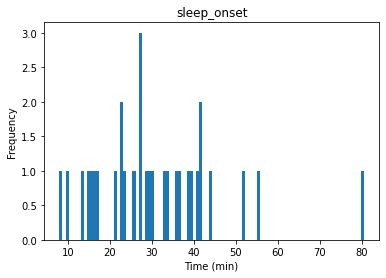

In [266]:
def plot_sleep_set(data, label="sleep_onset"):
    d = pd.Series(data)
    d.name = label
    ax = d.dt.total_seconds().div(60).plot.hist(bins=100)
    ax.set_title(label)
    ax.set_xlabel("Time (min)")
    return ax


plot_sleep_set(save_on_set, label="sleep_onset")




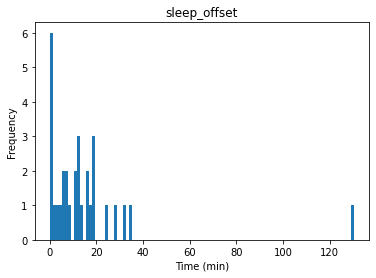

In [268]:
plot_sleep_set(save_off_set, label="sleep_offset")